In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Data Road

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/TestData.csv')
print(df.shape)
df

(43771, 14)


지역  시간      발전량          일자   기온   풍속     풍향    습도    해면기압    일사  \
0      전남 목포시   9   20.160  2013-01-01  2.6  6.0  290.0  91.0  1019.6  0.03   
1      전남 목포시  10  106.800  2013-01-01  4.2  5.8  250.0  82.0  1019.9  0.57   
2      전남 목포시  11  469.560  2013-01-01  3.8  7.1  320.0  80.0  1020.5  1.00   
3      전남 목포시  12  504.240  2013-01-01  4.9  2.8  290.0  73.0  1020.1  1.05   
4      전남 목포시  13  745.200  2013-01-01  5.2  6.7  320.0  66.0  1019.7  1.14   
...       ...  ..      ...         ...  ...  ...    ...   ...     ...   ...   
43766  강원 강릉시  13   35.328  2020-12-31 -1.1  3.2  200.0  24.0  1020.1  1.94   
43767  강원 강릉시  14   36.864  2020-12-31  0.0  2.6  360.0  22.0  1019.5  1.80   
43768  강원 강릉시  15  401.280  2020-12-31  0.3  4.5  230.0  27.0  1019.1  1.47   
43769  강원 강릉시  16  382.464  2020-12-31 -0.1  4.0  230.0  29.0  1019.2  0.94   
43770  강원 강릉시  17  150.048  2020-12-31 -1.8  4.0  250.0  34.0  1019.5  0.36   

        전운량      시정  PM10   월  
0      10.0  1300.0  43.0   1  
1       7.0  1300.0  56.0   1  
2       9.0  1300.0  75.0   1  
3       7.0  1300.0  84.0   1  
4       6.0  1100.0  78.0   1  
...     ...     ...   ...  ..  
43766   0.0  5000.0  13.0  12  
43767   0.0  5000.0  11.0  12  
43768   0.0  5000.0  16.0  12  
43769   0.0  5000.0  13.0  12  
43770   0.0  5000.0  20.0  12  

[43771 rows x 14 columns]

In [ ]:
area_name = ['Gn', 'Jj', 'Mp' ] 
for idx, area in enumerate(['강원 강릉시','경남 진주시', '전남 목포시']): #지역별로 데이터 분리
  name = area_name[idx]
  data = df[df['지역'] == area]
  data.reset_index(drop=True, inplace=True)
  globals()[f'{name}_df'] = data
print(f'전체데이터: {df.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

전체데이터: (43771, 14),
목포시 : (26389, 14),
강릉시 : (8908, 14),
진주시 : (8474, 14)


# Train, Test Split

In [ ]:
# Train Set의 편차열 생성 함수
def deviation(data, cols): 
  df = data.copy()
  cols.extend(['월','시간']) # 평균 계산할때 기준
  #변수 별로 월, 시간 평균 계산하기
  mean_df = pd.DataFrame() # 평균 계산한 df
  for m in df['월'].unique():
    for h in df['시간'].unique():
      mn = np.array(df[(df['월'] == m) & (df['시간'] == h)][cols].mean())
      mean_data = pd.DataFrame([mn], columns = cols)
      mean_df = pd.concat([mean_df, mean_data])

  mean_df.dropna(how='any', inplace=True)
  mean_df.reset_index(inplace=True, drop=True)
  mean_df[['시간','월']] = mean_df[['시간','월']].astype(int)

  # 기존 값에서 평균을 빼서 변수들의 편차열을 만듬
  del cols[-2:] # 추가한 평균, 월을 제외한 나머지를 편차로 생성
  dev_df = pd.DataFrame(0, index = df.index, columns = cols) # 편차열이 들어갈 df

  hours = mean_df['시간'].unique()
  months = mean_df['월'].unique()
  for m, h in [(x,y) for x in months for y in hours]:
    idx = df[(df['월'] == m) & (df['시간'] == h)].index
    m_idx = mean_df[(mean_df['월'] == m) & (mean_df['시간'] == h)].index
    dev_df.loc[idx, cols] = df.loc[idx, cols] - mean_df.loc[m_idx, cols].squeeze()

  # 편차 df 이름 변경
  rename_c = [i+'편차' for i in dev_df.columns]
  dev_df.columns = rename_c

  return mean_df, dev_df

In [ ]:
# train, test_set 생성함수
def MakeDataSet(df, area, cols, target):
  # 마지막 년도를 test로 사용
  test_year = df['일자'].str[:4].unique().max()
  last_year = df[df['일자'] >= f'{test_year}-01-01'].index[0]
  train = df[df.index < last_year]  
  test = df[df.index >= last_year]

  feature_cols = [x for x in cols if x not in ['발전량']]

  if target == '발전량편차':
    mean_train, dev_df = deviation(train, cols) #train-set 편차열을 생성
    feature_train = [x+'편차' for x in feature_cols]
    x_train = dev_df[feature_train]
    y_train = dev_df[[target]]

    #train-set에서 계산된 발전량 평균값을 나중에 학습 후 test-set 예측에 사용
    mn_df = pd.merge(test[['월','시간','발전량']], mean_train[['월','시간','발전량']], on=['월','시간'], how='left')
    mn_df.rename(columns ={'발전량_y':'발전량평균'}, inplace=True)
    testmn = mn_df[['발전량평균']].squeeze()
    testmn = testmn.fillna(0)

    # test-set도 편차열을 생성
    # target은 train과 달리 편차가 아닌 발전량을 예측한다.
    mean_test, dev_df = deviation(test, cols)
    x_test = dev_df[feature_train]

  else:
    x_train = train[feature_cols]
    y_train = train[['발전량']]
    x_test = test[feature_cols]
    testmn = None

  # 편차, 기존 변수 학습후에도 test target은 발전량
  y_test = test[['발전량']]

  print(f'{area} train: {x_train.shape}, {y_train.shape} test: {x_test.shape}, {y_test.shape}')
  print('Train-set: ', ', '.join(x_train.columns), y_train.columns,'\nTest-set : ', ', '.join(x_test.columns), y_test.columns) #선택된 변수
  return testmn, x_train, y_train, x_test, y_test

In [ ]:
cols = [x for x in df.columns if x not in ['일자','지역','월','시간']]
cols

['발전량', '기온', '풍속', '풍향', '습도', '해면기압', '일사', '전운량', '시정', 'PM10']

# Model-based Learning

In [ ]:
RMSE = {} #score점수를 저장 
R2 = {}

In [ ]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name, area_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{area_name} {model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{area_name} {model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

In [ ]:
# 모델 학습 최종 모델

def ModelTest(df, model, area, area_name, cols, target):
  # target에 맞춰 편차변수 or 일반 변수가 train set 으로 생성
  # 학습만 그렇게 나눠 진행되고 test를 통한 성능 비교는 동일하게 일반 변수
  testmn, x_train, y_train, x_test, y_test = MakeDataSet(df, area, cols, target)

  model_list = {'LR':LinearRegression(),
                'RF': RandomForestRegressor(n_estimators = 700),
                'MLP':  MLPRegressor(max_iter=2000)}

  if model == 'LGB':
    lgb_dtrain = lgb.Dataset(data = x_train, label = y_train) # LightGBM 모델에 맞게 변환
    lgb_param = {'max_depth': 10,
            'learning_rate': 0.2, # Step Size
            'objective': 'regression', # 목적 함수 (L2 Loss)
    }
    LGB_model = lgb.train(params = lgb_param, train_set = lgb_dtrain)
    shap_model = LGB_model
    # LGB score
    y_test_pred = LGB_model.predict(x_test) #기존 변수 사용
    R2_score = r2_score(y_test, y_test_pred) #LGB만 계산이 다름


  else:
    globals()[f'{model}_model'] = model_list[model].fit(x_train, y_train.values.ravel())
    shap_model = globals()[f'{model}_model']
    # score
    y_test_pred = globals()[f'{model}_model'].predict(x_test) #기존 변수 사용
    R2_score = r2_score(y_test_pred, y_test) 

  #score 평가
  if target == '발전량편차':
    # test 정확도
    Y_pred = y_test_pred + testmn # 편차 사용 (예측 편차 + 평균값)
    if model == 'LGB': 
      R2_dev = r2_score(y_test, Y_pred) #LGB만 계산이 다름
    else:
      R2_dev = r2_score(Y_pred, y_test)
    RMSE_dev = sqrt(mean_squared_error(Y_pred, y_test))
    #점수 저장
    R2[f'Dev_{model}_{area}'] = R2_dev
    RMSE[f'Dev_{model}_{area}'] = RMSE_dev
  else:
    RMSE_score = sqrt(mean_squared_error(y_test_pred, y_test))
    R2[f'{model}_{area}'] = R2_score
    RMSE[f'{model}_{area}'] = RMSE_score
    
  # shap plot
  ShapPlot(shap_model, x_train, f'{model}', area_name)

## Jinjo

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5836it [01:20, 64.77it/s]                          


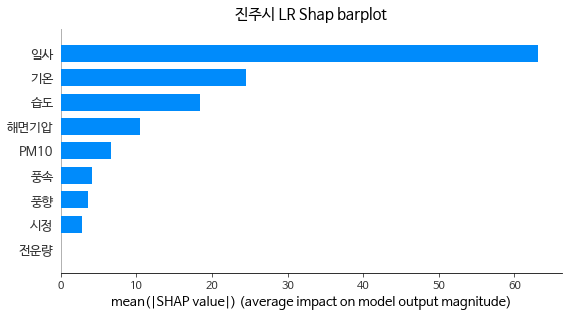

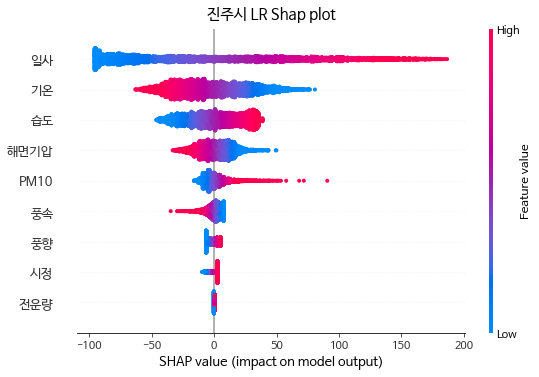

In [ ]:
ModelTest(Jj_df, 'LR', 'Jj', '진주시', cols, '발전량')

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5836it [01:17, 64.43it/s]                          


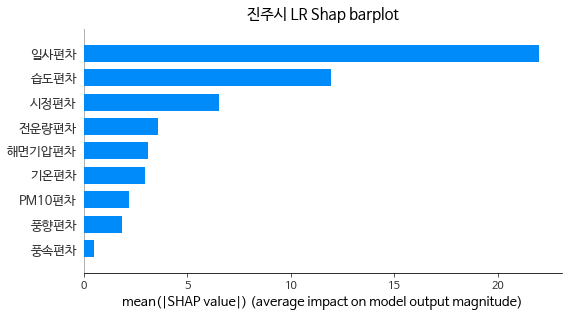

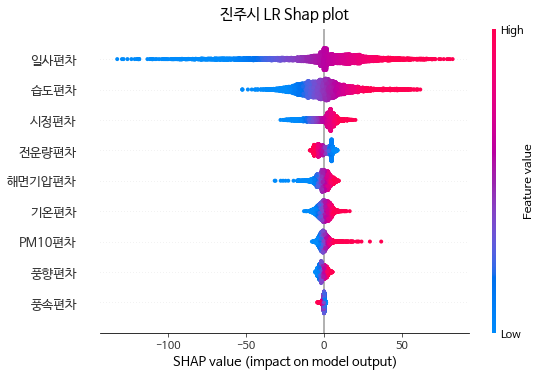

In [ ]:
ModelTest(Jj_df, 'LR', 'Jj', '진주시', cols, '발전량편차')

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5836it [27:06,  3.57it/s]


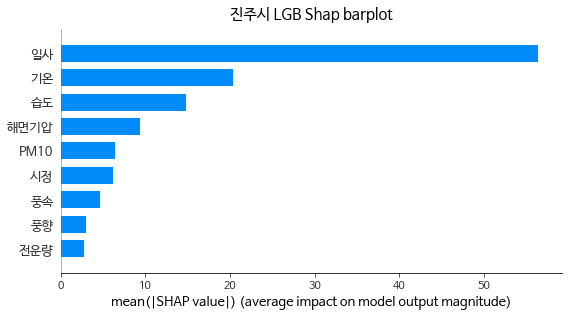

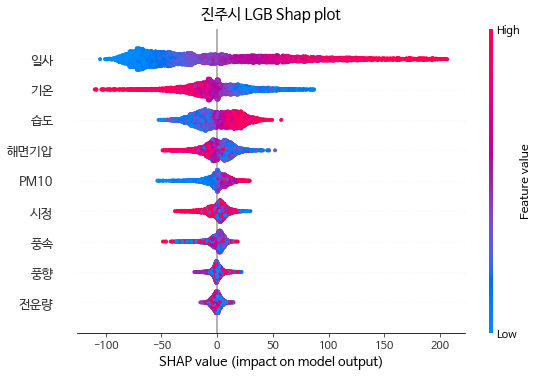

In [ ]:
ModelTest(Jj_df, 'LGB', 'Jj', '진주시', cols, '발전량')

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5836it [27:50,  3.47it/s]


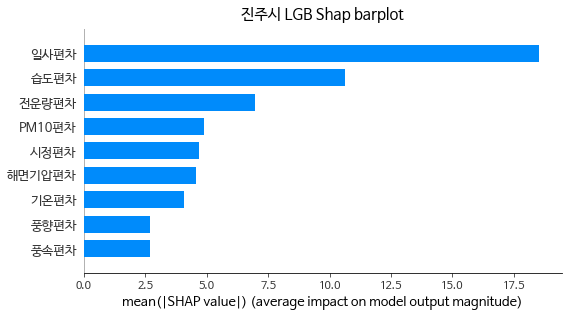

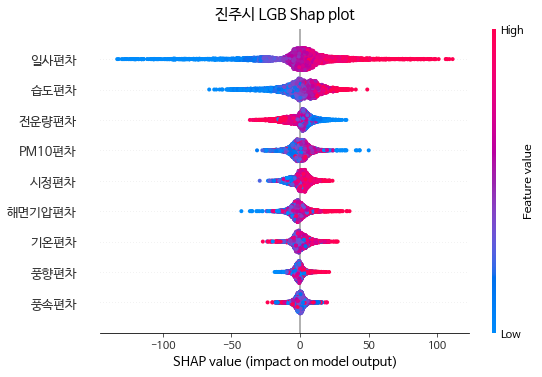

In [ ]:
ModelTest(Jj_df, 'LGB', 'Jj', '진주시', cols, '발전량편차')

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5836it [07:27, 12.72it/s]                          


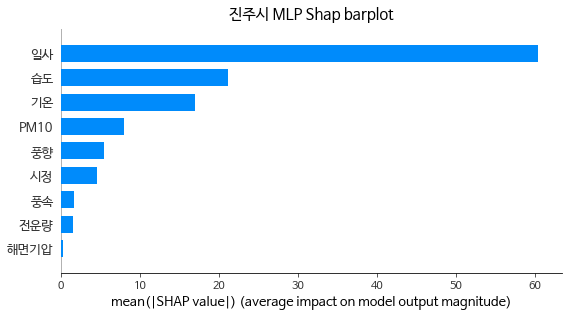

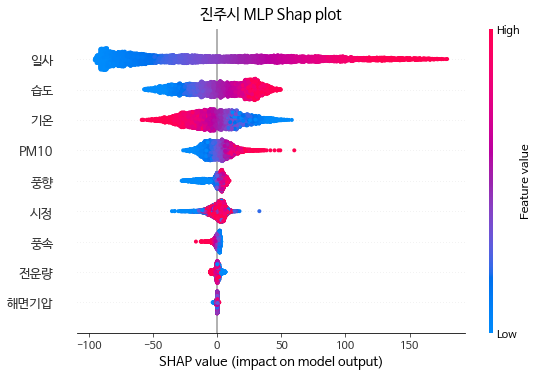

In [ ]:
ModelTest(Jj_df, 'MLP', 'Jj', '진주시', cols, '발전량')

Jj train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5836it [08:07, 11.72it/s]


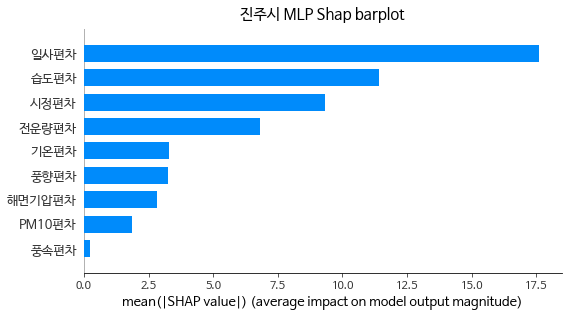

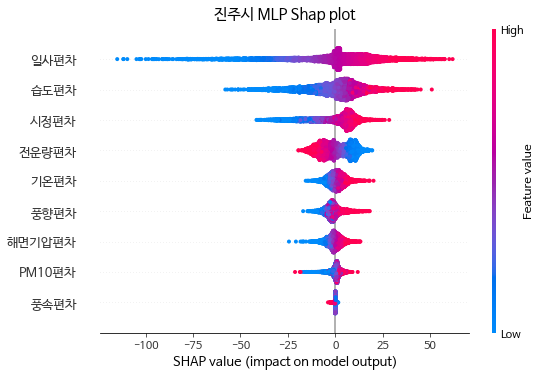

In [ ]:
ModelTest(Jj_df, 'MLP', 'Jj', '진주시', cols, '발전량편차')

## Gangneung

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5042it [01:07, 61.68it/s]                          


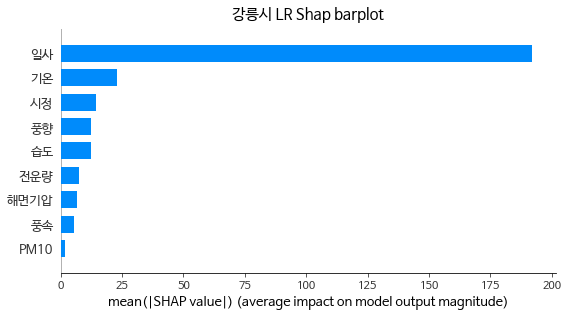

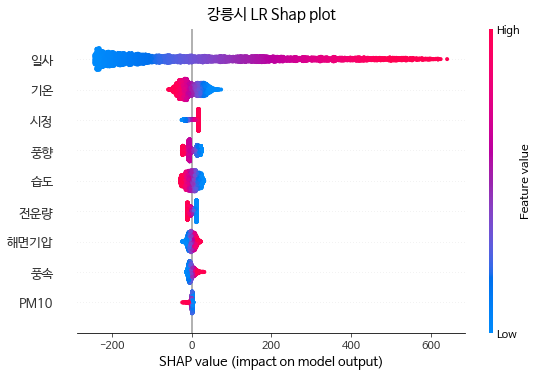

In [ ]:
ModelTest(Gn_df, 'LR', 'Gn', '강릉시', cols, '발전량')

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5042it [01:11, 59.91it/s]                          


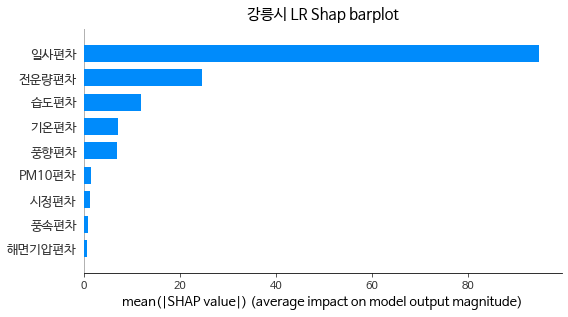

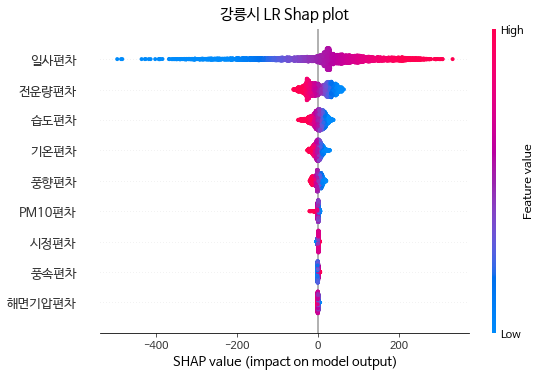

In [ ]:
ModelTest(Gn_df, 'LR', 'Gn', '강릉시', cols, '발전량편차')

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5042it [25:18,  3.30it/s]


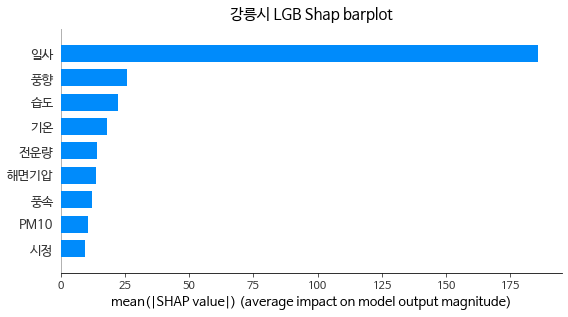

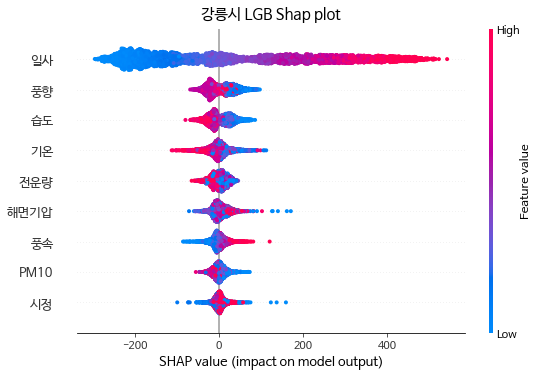

In [ ]:
ModelTest(Gn_df, 'LGB', 'Gn', '강릉시', cols, '발전량')

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5042it [27:54,  2.99it/s]


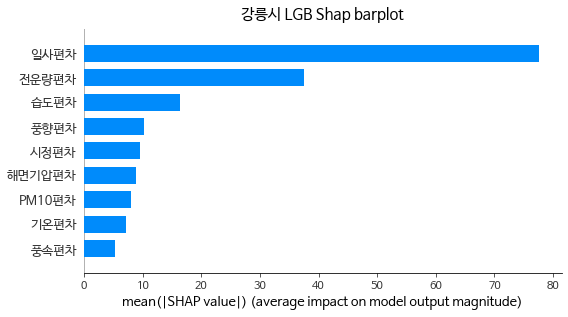

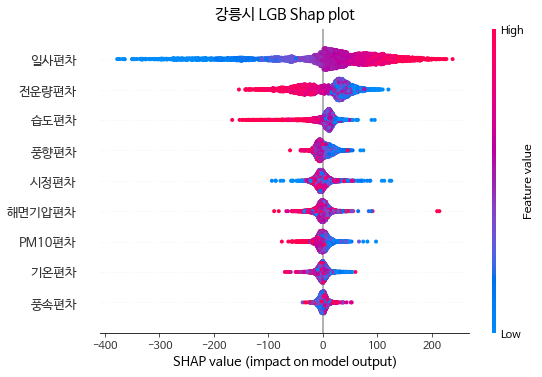

In [ ]:
ModelTest(Gn_df, 'LGB', 'Gn', '강릉시', cols, '발전량편차')

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 5042it [04:43, 17.09it/s]


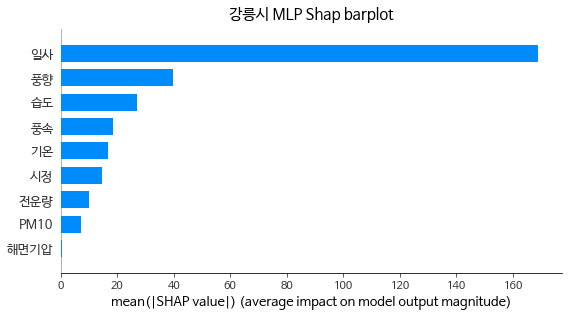

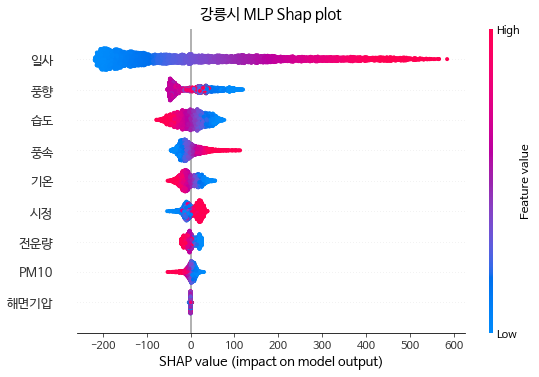

In [ ]:
ModelTest(Gn_df, 'MLP', 'Gn', '강릉시', cols, '발전량')

Gn train: (5041, 9), (5041, 1) test: (3867, 9), (3867, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 5042it [05:35, 14.46it/s]                          


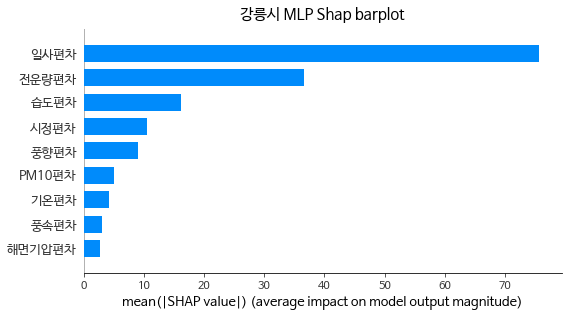

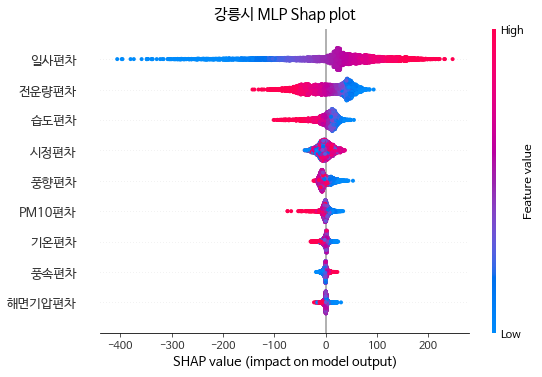

In [ ]:
ModelTest(Gn_df, 'MLP', 'Gn', '강릉시', cols, '발전량편차')

## Mokpo

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 22065it [05:26, 65.32it/s]                           


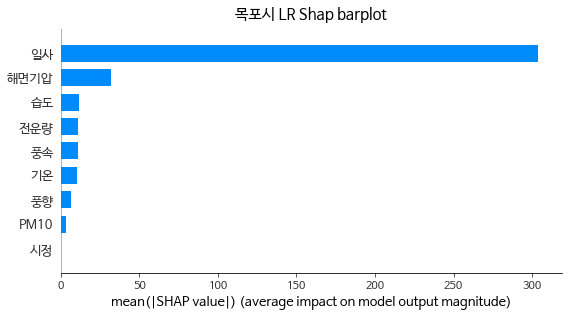

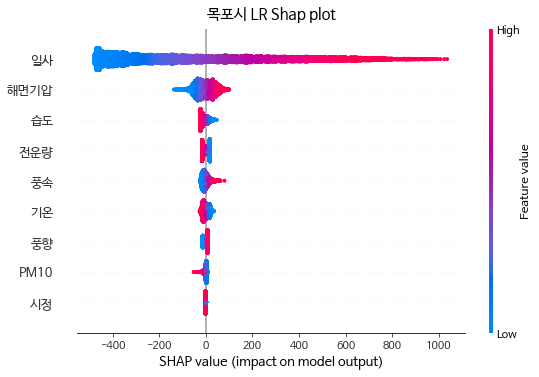

In [ ]:
ModelTest(Mp_df, 'LR', 'Mp', '목포시', cols, '발전량')

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 22065it [04:32, 78.14it/s]                           


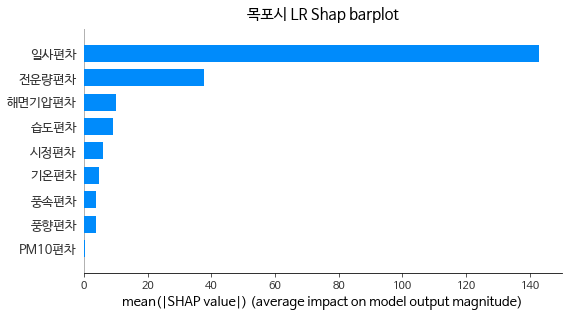

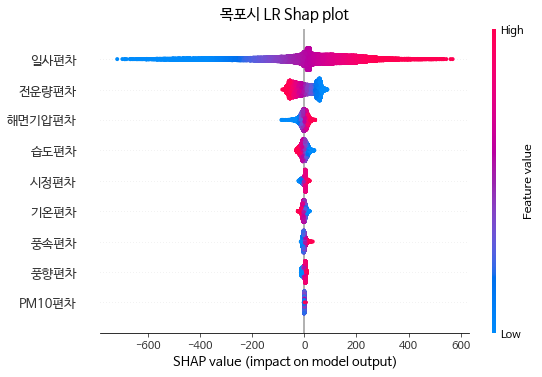

In [ ]:
ModelTest(Mp_df, 'LR', 'Mp', '목포시', cols, '발전량편차')

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 22065it [1:15:37,  4.85it/s]


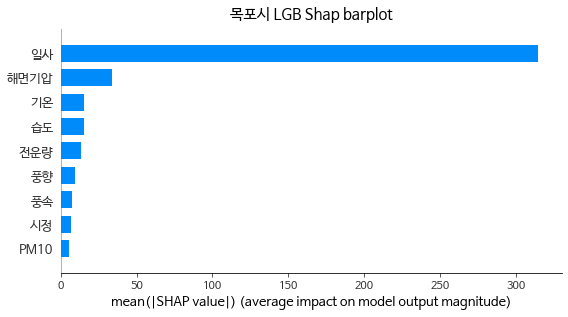

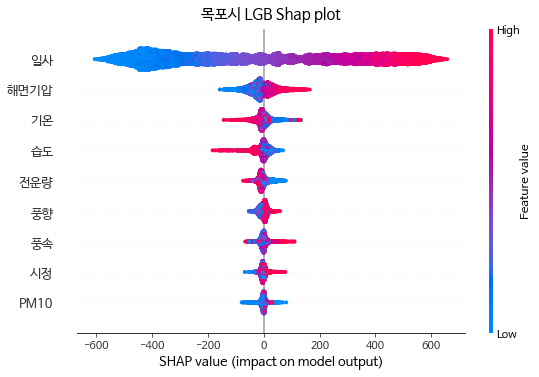

In [ ]:
ModelTest(Mp_df, 'LGB', 'Mp', '목포시', cols, '발전량')

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 22065it [1:20:27,  4.56it/s]


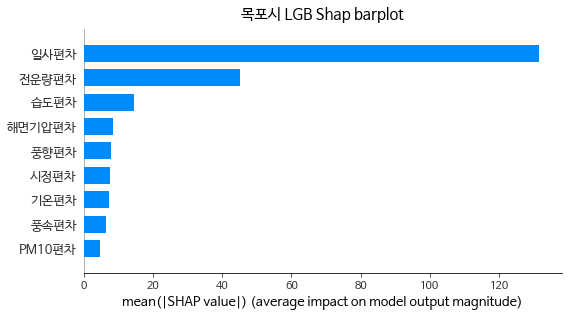

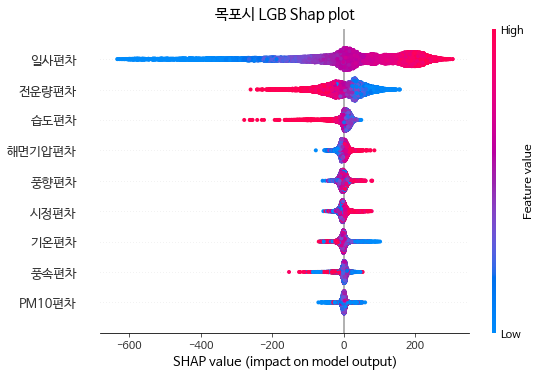

In [ ]:
ModelTest(Mp_df, 'LGB', 'Mp', '목포시', cols, '발전량편차')

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object') 
Test-set :  기온, 풍속, 풍향, 습도, 해면기압, 일사, 전운량, 시정, PM10 Index(['발전량'], dtype='object')


Exact explainer: 22065it [35:17, 10.36it/s]


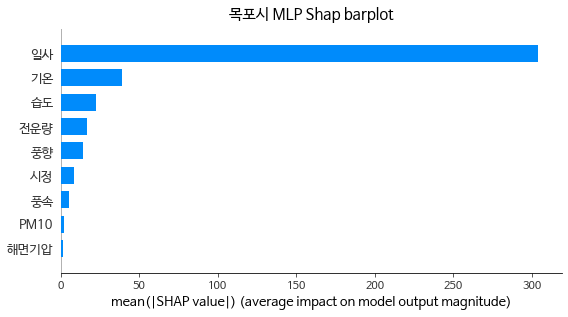

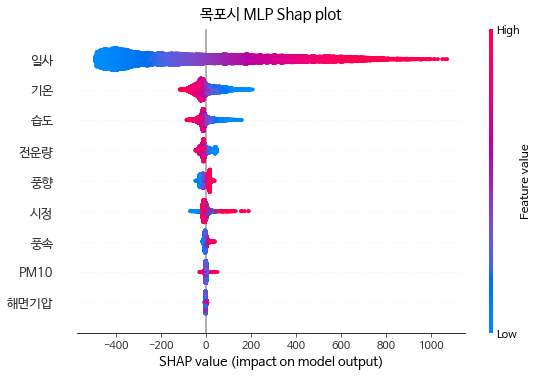

In [ ]:
ModelTest(Mp_df, 'MLP', 'Mp', '목포시', cols, '발전량')

Mp train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)
Train-set:  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량편차'], dtype='object') 
Test-set :  기온편차, 풍속편차, 풍향편차, 습도편차, 해면기압편차, 일사편차, 전운량편차, 시정편차, PM10편차 Index(['발전량'], dtype='object')


Exact explainer: 22065it [24:04, 15.18it/s]


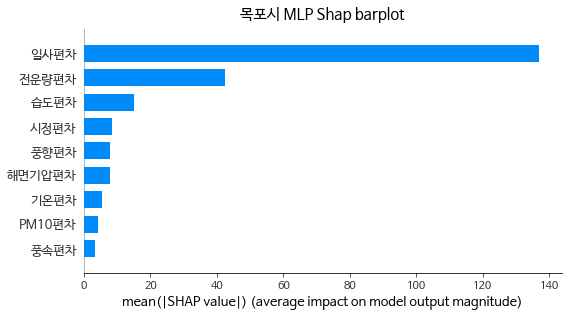

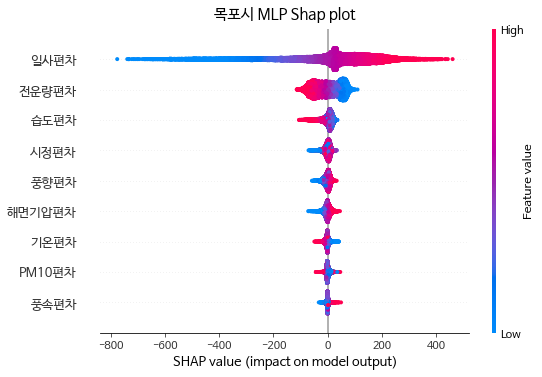

In [ ]:
ModelTest(Mp_df, 'MLP', 'Mp', '목포시', cols, '발전량편차')

# Save

In [ ]:
R2

{'Dev_LGB_Gn': -1.0738566418259143,
 'Dev_LGB_Jj': 0.5825870240347781,
 'Dev_LGB_Mp': 0.8911137965599081,
 'Dev_LR_Gn': -0.4156666324767655,
 'Dev_LR_Jj': 0.6270141424624222,
 'Dev_LR_Mp': 0.8750964324658537,
 'Dev_MLP_Gn': -0.37782943074936104,
 'Dev_MLP_Jj': 0.6247233802276031,
 'Dev_MLP_Mp': 0.8739375382021806,
 'LGB_Gn': -1.0985094611358073,
 'LGB_Jj': 0.6630854359055967,
 'LGB_Mp': 0.8766433724067961,
 'LR_Gn': -0.6155984618853694,
 'LR_Jj': 0.4555026705981564,
 'LR_Mp': 0.8387802644111342,
 'MLP_Gn': -0.4651281542624952,
 'MLP_Jj': 0.5334762051823634,
 'MLP_Mp': 0.8393473832482871}

In [ ]:
RMSE

{'Dev_LGB_Gn': 307.7864020754181,
 'Dev_LGB_Jj': 49.2675914382032,
 'Dev_LGB_Mp': 128.88409664154466,
 'Dev_LR_Gn': 308.60068826269844,
 'Dev_LR_Jj': 45.59267347164448,
 'Dev_LR_Mp': 135.86767612995203,
 'Dev_MLP_Gn': 304.23348244090147,
 'Dev_MLP_Jj': 45.4925932982477,
 'Dev_MLP_Mp': 134.3857366270244,
 'LGB_Gn': 309.6103916376756,
 'LGB_Jj': 44.26273555180476,
 'LGB_Mp': 137.1810580266899,
 'LR_Gn': 305.6520305931295,
 'LR_Jj': 44.954802729849796,
 'LR_Mp': 163.27979488504928,
 'MLP_Gn': 288.183233636051,
 'MLP_Jj': 42.26338000000575,
 'MLP_Mp': 167.06780703944113}

In [ ]:
with open ('/content/gdrive/MyDrive/SolarPower/RMSE_score.pickle','wb') as fw:
  pickle.dump(RMSE, fw)
with open ('/content/gdrive/MyDrive/SolarPower/R2_score.pickle','wb') as fw:
  pickle.dump(R2, fw)   